In [1]:
pwd

'C:\\Python Files\\AluminaConcEstimator\\NoteBooks'

In [2]:
import sys
sys.path.append('../')

In [3]:
# Do imports first
import Global as Glob
import Model as Mod
import numpy as np
import pandas as pd
import StateSimulation as StateSim
import UnscentedKalmanFilterSim as UKFSim

In [4]:
# define model at 5 sec intervals
dt = 5
(F, G, H, B) = Mod.StateEquations(dt)

In [5]:
# Define the UKF noise standard deviations
q1dstd = 0.001    # alumina concentration variation
q1ustd = 0.001  # undisolved alumina concentration variation
q2std = 0.0000005  # acd varation needs to be much lower
# array of state variation terms
qstd = np.array([[q1dstd], [q1ustd], [q2std]])
rstd = 0.01       # measurement variation (volts)

In [6]:
# start with initial concentrations at end of previous underfeed of:
# 2.3% dissolved
# 0.5% undissolved
# starting ACD of 26.1 mm
x0 = np.array([[2.3], [0.5], [2.6093]])

In [7]:
def LoadData(filename: str):
    # This is a quick loader - not finalised
    celldata = pd.read_csv(filename, sep=',')
    npcelldata = celldata.to_numpy()
    dims = np.shape(npcelldata)
    tsteps = dims[0]
    udim = 3
    zdim = 1
    u = np.zeros((tsteps, udim, 1))
    z = np.zeros((tsteps, zdim, 1))
    for i in range(tsteps):
        VCell = npcelldata[i, 0]
        Iline = npcelldata[i, 1]
        feed = npcelldata[i, 3]
        beammove = npcelldata[i, 4]
        uobs = np.array([[Iline], [feed], [beammove]])
        u[i] = np.copy(uobs)
        zobs = np.array([[VCell]])
        z[i] = np.copy(zobs)
    return u, z

In [8]:
# load in actual data for input and observation
ut, zt = LoadData("C:/Python Files/AluminaConcEstimator/DataImport/excel prototype.csv")

In [9]:
np.shape(ut)

(2116, 3, 1)

In [10]:
np.shape(zt)

(2116, 1, 1)

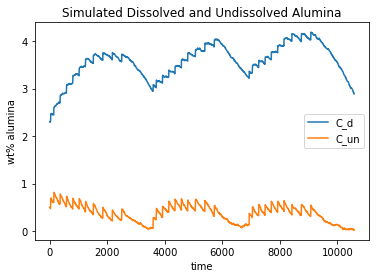

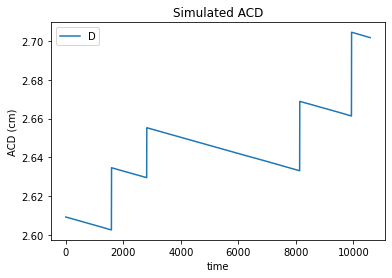

In [11]:
# simulate states with the true inputs, plot the results
xsim = StateSim.xtrue(F, G, B, qstd, x0, ut, dt, True)

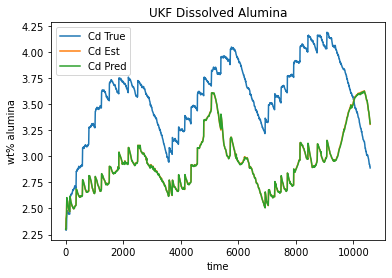

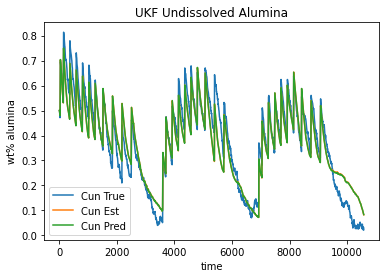

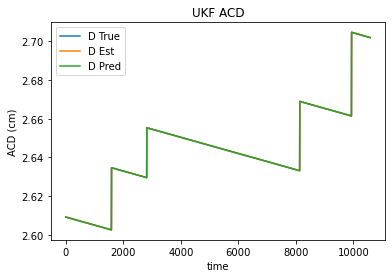

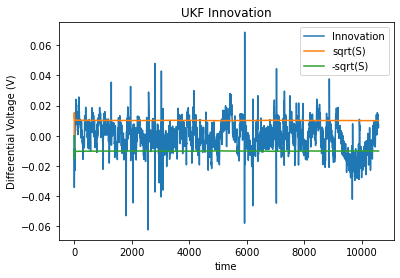

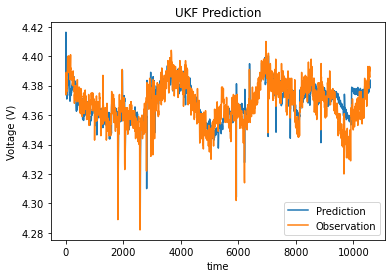

In [12]:
# Run the UKF SImulation using the nominal inputs
xest, Pest, xpred, Ppred, dz, S = UKFSim.ukf(F, G, H, B, qstd, rstd, zt, ut, x0, 0)
UKFSim.plot_ukf(xsim, zt, dz, xest, xpred, dt, S)

In [16]:
# Difference between what we predicted via UKF and what we simulated with the inputs and assumed state initialisation
diff = xpred-xsim

In [18]:
np.shape(diff)

(2116, 3, 1)

In [22]:
# both the C_d and C_un represent "observable" alumina in the cell, so the overall discrepancy is the combination of the two?
discrep = np.zeros((2116, 3, 1))
discrep[:, 0, :] = diff[:, 0, :] + diff[:, 1, :]
# not sure if it is additive or subtractive
discrep[:, 1, :] = diff[:, 0, :] - diff[:, 1, :]

In [23]:
discrep

array([[[0.        ],
        [0.        ],
        [0.        ]],

       [[0.00090684],
        [0.00853223],
        [0.        ]],

       [[0.08600743],
        [0.0826537 ],
        [0.        ]],

       ...,

       [[0.48553461],
        [0.37608774],
        [0.        ]],

       [[0.47762384],
        [0.35915418],
        [0.        ]],

       [[0.48407776],
        [0.36322481],
        [0.        ]]])

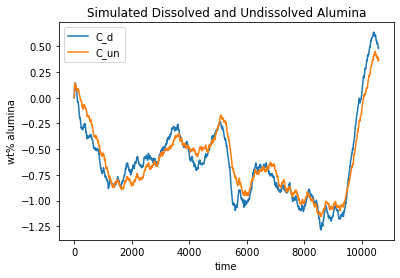

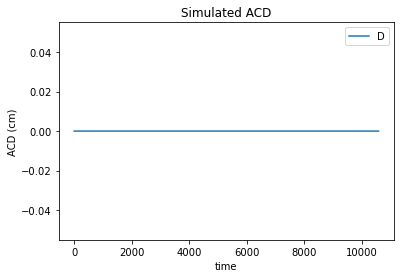

In [25]:
# hijacking the existing plot function, so the titles are wrong
# This is showing the xpred-xsim discrpancy over time and the two plots illustrate
# the difference between adding and subtracting dissolved and undissolved discrepancy
StateSim.plot_xsim(discrep, 5)